In [7]:
import datetime
import json
import math
import os
import pytz
import random
import re

from functools import reduce, partial
from joblib import Memory
from multiprocessing import Pool
from tempfile import mkdtemp
from typing import List

import nltk
import numpy as np
import pandas as pd
import umap.umap_ as umap
import umap.plot

import emoji
from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn import preprocessing, metrics
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, 
                             auc,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score, 
                             precision_score, 
                             RocCurveDisplay,
                             recall_score, 
                             roc_curve, 
                            )
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import randomized_svd
from textblob import TextBlob
from tqdm.auto import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

SEED = 806
np.random.seed(SEED)
plt.style.use("seaborn-bright")
random.seed(SEED)

[nltk_data] Downloading package punkt to /home/ray080186/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipykernel_17259/3026732915.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


In [9]:
game_start = 1422835961
game_end = 1422845700

In [10]:
data_dir = "/tmp2/kch/ece219/ECE219_tweet_data"
filename = "tweets_#superbowl.txt"
data = []

with open(os.path.join(data_dir, filename)) as f:
    for line in tqdm(f):
        all_info = json.loads(line)
        # print(all_info.keys())
        # print(all_info["tweet"]["user"])
        taken_info = {
            "type": all_info["type"],
            # "title": all_info["title"],
            "text": all_info["tweet"]["text"],
            "id": all_info["tweet"]["id"],
            "hashtags": " ".join([
                " ".join([s for s in re.split('([A-Z][a-z]+)', h["text"]) if s]) 
                for h in all_info["tweet"]["entities"]["hashtags"]
            ]),  # hashtag split
            "location": all_info["tweet"]["user"]['location'],
            "citation_date": all_info["citation_date"],
        }
        if (
            game_start < taken_info["citation_date"] <= game_end
            and taken_info["text"] != ""
        ):
            data.append(taken_info)

data_df = pd.DataFrame(data)

0it [00:00, ?it/s]

In [11]:
len(data_df)

501976

In [12]:
# "NE"
# "TIE"
# "SEA"

# leading_label is who is leading the game starting from the timestamp

# not sure if it is accurate since I am not able to 
# transfer the time into absolute time using the following link
# https://www.espn.com/nfl/playbyplay/_/gameId/400749027
# I am wasting too much time here so I just use the rough time by searching and checking from the tweet

scoring_timestamp = [
    game_start,
    1422837233,
    1422838078,
    1422838706,
    1422841071,
    1422842032,
    1422844038,
    1422845360,
]
leading_results = ['NE', 'TIE', 'NE', 'TIE', 'SEA', 'SEA', 'SEA', 'NE']
map_row_to_class = {"NE": 0, "SEA": 1, "TIE": 2}
conditions = []

for i in range(1, len(scoring_timestamp)):
    conditions.append(
        data_df["citation_date"].between(scoring_timestamp[i-1], scoring_timestamp[i]-1)
    )
conditions.append(data_df["citation_date"] >= scoring_timestamp[-1])


data_df['leading_label'] = np.select(
    conditions,
    leading_results,
    np.nan
)
data_df['leading_label_cat'] = data_df.leading_label.map(map_row_to_class)

data_df["full_text"] = data_df["text"] + " " + data_df["hashtags"]


In [13]:
data_df[["leading_label", "leading_label_cat"]].value_counts()

leading_label  leading_label_cat
TIE            2                    241432
SEA            1                    149033
NE             0                    111511
dtype: int64

In [14]:
# Replace special chars with space
__CHARS_TO_REPLACE = [",", ";", "\t", "...", "\"", "\n", "\xa0"]
__CHARS_TO_REPLACE_REGEX = re.compile("|".join(map(re.escape, __CHARS_TO_REPLACE)))

# Adding heading ahd trailing space on special chars
__CHARS_ADD_SPACE = ["?", "-", ":", "_", "(", ")", "!", "/", ".", "℠", "™", "@", "©", "®", "℗"]
__CHARS_ADD_SPACE_REGEX = re.compile("|".join(map(re.escape, __CHARS_ADD_SPACE)))

# Replace special pattern with space
__PATTERN_TO_REPLACE = [
    r'(\s(and)*\s*[0-9]*\s*(more|other)\s*items*\s)',  # eliminate other items
    r'(\s\(\s*\)\s)'  # remove empty brackets
]
__PATTERN_TO_REPLACE_REGEX = re.compile("|".join(__PATTERN_TO_REPLACE))

# Remove excess space
__REMOVE_EXCESS_SPACE_REGEX = re.compile(r'\s+')

# XML standard defines a valid character as
# Char ::= #x9 | #xA | #xD | [#x20-#xD7FF] | [#xE000-#xFFFD] | [#x10000-#x10FFFF]
__RGX_XML_CNTRL_CHR = re.compile(u'[^\u0020-\uD7FF\u0009\u000A\u000D\uE000-\uFFFD\U00010000-\U0010FFFF]+')

# Regex to match money value
__RGX_MONEY = re.compile(r'(?:[^\d]|\b)(?:\d{1,2},)?\d{1,4}(?:[.,]\d{1,2})\s*(?:us\$|usd|\$)*(?:[^\d]|\b)|'
                         '(free$)|'
                         r'(?:us\$|\$|usd|us \$) *-? *\d{1,4}(?:[.,]\d{1,2})?(\s*)(?:us\$|usd|\$)*(?:[^\d]|\b)|'
                         r'\d{1,4}(?:[.,]\d{1,2})? *(?:us\$|usd|\$)')
__REPLACE_RGX_MONEY = ' $#money#$ '

# Time related regex
__YEAR_NUM = r'(19[7-9][0-9]|20[0-2][0-9]|[0-2][0-9])'
__MONTH_SHORT = r'(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)'
__MONTH_LONG = r'(january|february|march|april|may|june|july|august|september|october|november|december)'
__MONTH = r'(?:%s)' % '|'.join([__MONTH_LONG, __MONTH_SHORT, r'0[1-9]|[1-9]|1[0-2]'])
__DAY_NUM = r'([012][1-9]|[123][0-1]|[1-9])'
__DATE_SEP = r"(/|-|,|\s)"

# Add ? quantifier to solves "feb 3 2018" substitute to "$#date#$ $#number#$" instead of "$#date#$" problem
__DATE_LIST = [
    f'({__MONTH}({__DATE_SEP}+){__DAY_NUM}(?:({__DATE_SEP}+){__YEAR_NUM})?)',
    f'({__DAY_NUM}({__DATE_SEP}+){__MONTH}(?:({__DATE_SEP}+){__YEAR_NUM})?)',
    f'({__MONTH}({__DATE_SEP}+){__YEAR_NUM}(?:({__DATE_SEP}+){__DAY_NUM})?)',
    f'({__YEAR_NUM}({__DATE_SEP}+){__MONTH}(?:({__DATE_SEP}+){__DAY_NUM})?)',
]

__RGX_MONTH = ' (?:%s) ' % '|'.join([__MONTH_LONG, __MONTH_SHORT])
__REPLACE_RGX_MONTH = ' $#month#$ '
__RGX_DATE = re.compile(r'\s(?:%s)\s' % '|'.join(__DATE_LIST))
__REPLACE_RGX_DATE = ' $#date#$ '
__RGX_TIME = re.compile(r'\s((0[1-9]|[1-9]|1[0-9]|2[0-4])(\s*\:\s*([0-9]|[0-5][0-9])){1,2}\s*(?:am|pm|))\s')
__REPLACE_RGX_TIME = ' $#time#$ '

# DIGIT and Numbers
__RGX_DIGIT = re.compile(r'\d+')
__REPLACE_RGX_DIGIT = ' $#number#$ '
__RGX_DIGIT_TEXT = re.compile(
    r'(\d+[a-z]+\d+|[a-z]+\d+[a-z]+|[a-z]+\d+|\d+[a-z]+)*(\d+[a-z]+\d+|[a-z]+\d+[a-z]+|[a-z]+\d+|\d+[a-z]+)+')
__REPLACE_RGX_DIGIT_TEXT = ' $#textnum#$ '


def normalize_text(desc: str) -> str:
    """
    normalize the incoming description string for cme
    :param desc: description string
    :return: normalized description string
    """
    normalize_steps = [
        lambda s: " " + s.lower() + " ",
        lambda s: re.sub(__CHARS_TO_REPLACE_REGEX, " ", s),
        lambda s: re.sub(__CHARS_ADD_SPACE_REGEX, lambda m: " " + m.group(0) + " ", s),
        lambda s: re.sub(__PATTERN_TO_REPLACE_REGEX, " ", s),
        lambda s: re.sub(__REMOVE_EXCESS_SPACE_REGEX, " ", s),
        lambda s: s.strip(),
        # lambda s: s if s else "$#empty#$"
        lambda s: s if s else " "
    ]
    return compose(*normalize_steps)(desc)


def normalize_text_advanced(text: str) -> str:
    """
    normalize the text string for suprabbx
    :param text: subject + sender string
    :return: normalized subject + sender string
    """
    normalize_steps = [
        lambda s: " ".join([a for a in re.split('([A-Z][a-z]+)', s) if a]),
        lambda s: emoji.demojize(s, language='en'),
        lambda s: " " + str(s).lower() + " ",
        lambda s: re.sub(__RGX_XML_CNTRL_CHR, " ", s),
        lambda s: re.sub(__RGX_MONEY, __REPLACE_RGX_MONEY, s),
        lambda s: re.sub(__CHARS_TO_REPLACE_REGEX, " ", s),
        lambda s: re.sub(__CHARS_ADD_SPACE_REGEX, lambda m: " " + m.group(0) + " ", s),
        lambda s: re.sub(__PATTERN_TO_REPLACE_REGEX, " ", s),
        # Replace single space with multiple spaces to solve `xxx oct nov xxx` problem
        lambda s: re.sub(" ", "  ", s),
        lambda s: re.sub(__RGX_TIME, __REPLACE_RGX_TIME, s),
        lambda s: re.sub(__RGX_DATE, __REPLACE_RGX_DATE, s),
        lambda s: re.sub(__RGX_MONTH, __REPLACE_RGX_MONTH, s),
        lambda s: re.sub(__RGX_DIGIT_TEXT, __REPLACE_RGX_DIGIT_TEXT, s),
        lambda s: re.sub(__RGX_DIGIT, __REPLACE_RGX_DIGIT, s),
        lambda s: re.sub(__REMOVE_EXCESS_SPACE_REGEX, " ", s),
        lambda s: s.strip(),
        # lambda s: s if s else "$#empty#$"
        lambda s: s if s else " "

    ]
    return compose(*normalize_steps)(text)


def compose(*functions):
    """
    compose multiple single argument functions together
    e.g., f3(f2(f1(x)))
    (f1 takes effect first, then f2, then f3)
    can be written as:
    func_list = [f1, f2, f3]
    compose(*func_list)(x)
    """
    return lambda x: reduce(lambda acc, f: f(acc), functions, x)


In [15]:
def average(lst): 
    if len(lst):
        return sum(lst) / len(lst) 
    else: 
        return 0
    
def get_sentiment(sen):
    sen_score = average(
        [
            s.sentiment.polarity
            for s in TextBlob(sen).sentences if s.sentiment.polarity != 0
        ]
    )
    
    if sen_score >= 0.5:
        return 3
    if sen_score > 0.0:
        return 1
    if sen_score == 0.0:
        return 0
    if sen_score > -0.5:
        return -1
    else:
        return -3

In [16]:
def preprocess_text(text, stemming=True, normalize=True):
    if stemming:
        text = stem(text)
    if normalize:
        text = normalize_text_advanced(text)
    return text


def stem(text):
    stemmer = PorterStemmer()
    # Reference: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
    tokens = word_tokenize(text)
    text = " ".join([stemmer.stem(word.lower()) for word in tokens])
    return text

In [17]:
def evaluate_mul(y_test, y_pred, average=None, clf=None):
    print("=" * 20)
    
    # confusion matrix
    labels = clf.classes_ if clf is not None else None
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_display.plot()
    plt.show()
    
    acc = round(accuracy_score(y_test,y_pred), 5)
    
    print(f"Accuracy: {acc}")
    print(f"Recall: {recall_score(y_test, y_pred, average=None)}")
    print(f"Precision: {precision_score(y_test, y_pred, average=None)}")
    print(f"F-1 score: {f1_score(y_test, y_pred, average=None)}")
    print("=" * 20)
    print()
    
    return acc

In [18]:
def get_train_test_indices(n, test_size):
    n_train = round(n * (1 - test_size))
    all_idxs = list(range(n))
    random.shuffle(all_idxs)
    return all_idxs[:n_train], all_idxs[n_train:]


train_idxs, test_idxs = get_train_test_indices(len(data_df), test_size=0.9)
train_mul, test_mul = data_df.iloc[train_idxs], data_df.iloc[test_idxs]

In [13]:
def run_pipeline_and_get_accuracy(
    stemming, normalize, add_location, add_sentiment, dimension_reduction
):
    # preprocess text
    with Pool(24) as pool:
        train_mul["full_text_processed"] = pool.starmap(
            preprocess_text,
            [(t, stemming, normalize) for t in train_mul["full_text"]],
        )
        test_mul["full_text_processed"] = pool.starmap(
            preprocess_text,
            [(t, stemming, normalize) for t in test_mul["full_text"]],
        )
    
    # location
    if add_location:
        train_mul["full_text_processed"] += " " + train_mul["location"]
        test_mul["full_text_processed"] += " " + test_mul["location"]
    
    # tf-idf
    pipe = Pipeline(
        [
            ("count", CountVectorizer(stop_words="english", min_df=3)),
            ("tfidf", TfidfTransformer()),
        ]
    )
    X_train_mul = pipe.fit_transform(train_mul["full_text_processed"])
    X_test_mul = pipe.transform(test_mul["full_text_processed"])
    
    # dimension reduction
    n_components = 80
    if dimension_reduction == "nmf":
        model = NMF(init="random", n_components=n_components, random_state=SEED)
    elif dimension_reduction == "svd":
        model = TruncatedSVD(n_components=n_components, random_state=SEED)
    
    X_train_mul_reduced = model.fit_transform(X_train_mul) 
    X_test_mul_reduced = model.transform(X_test_mul)
    
    # add sentiment feature
    if add_sentiment:
        with Pool(24) as pool:
            sentiments_train = pool.map(get_sentiment, train_mul["full_text_processed"])
            sentiments_test = pool.map(get_sentiment, test_mul["full_text_processed"])

        X_train_mul_reduced = np.concatenate(
            (X_train_mul_reduced, np.expand_dims(np.array(sentiments_train), 1)), axis=1
        )
        X_test_mul_reduced = np.concatenate(
            (X_test_mul_reduced, np.expand_dims(np.array(sentiments_test), 1)), axis=1
        )
    
    # classifier
    one_one_svm = OneVsOneClassifier(LinearSVC(random_state=SEED))
    y_pred = one_one_svm.fit(
        X_train_mul_reduced, train_mul["leading_label_cat"]
    ).predict(X_test_mul_reduced)
    acc = evaluate_mul(
        test_mul["leading_label_cat"], y_pred, average=None, clf=one_one_svm
    )
    
    return acc

stemming=True, normalize=True, add_sentiment=True, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

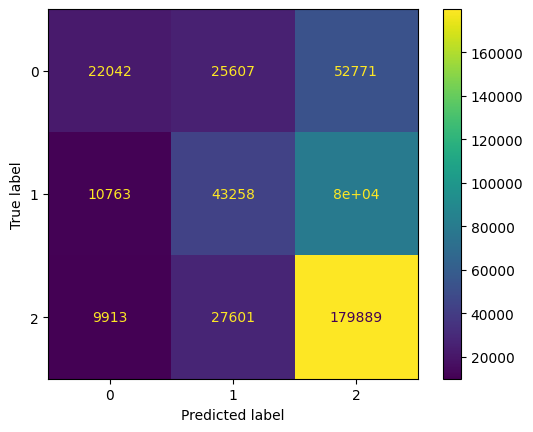

Accuracy: 0.54272
Recall: [0.21949811 0.32292934 0.82744488]
Precision: [0.51598858 0.44842743 0.5754717 ]
F-1 score: [0.30798251 0.37546925 0.67883026]

stemming=True, normalize=True, add_sentiment=True, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


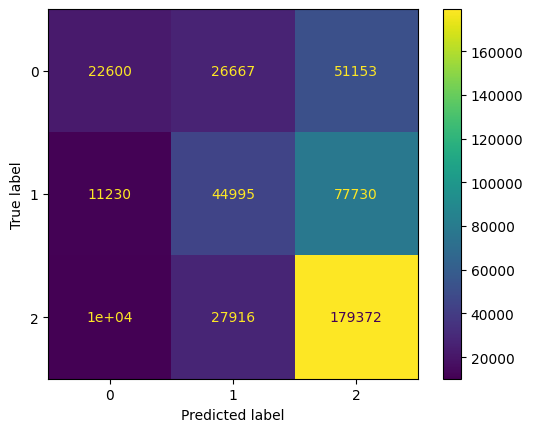

Accuracy: 0.54666
Recall: [0.22505477 0.33589638 0.82506681]
Precision: [0.51427921 0.45185684 0.58189486]
F-1 score: [0.31309528 0.38534169 0.68246655]

stemming=True, normalize=True, add_sentiment=False, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

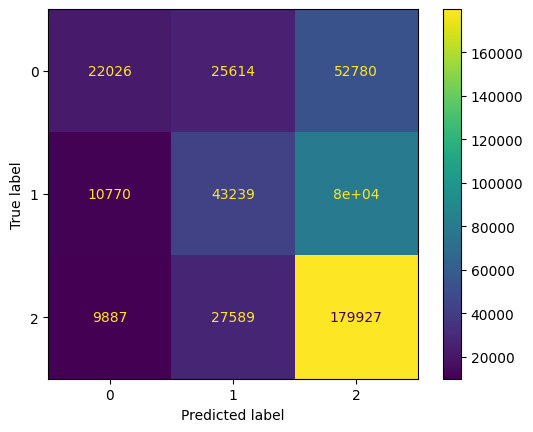

Accuracy: 0.54273
Recall: [0.21933878 0.3227875  0.82761967]
Precision: [0.51603683 0.44834201 0.57548464]
F-1 score: [0.30783422 0.37534343 0.67889808]

stemming=True, normalize=True, add_sentiment=False, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


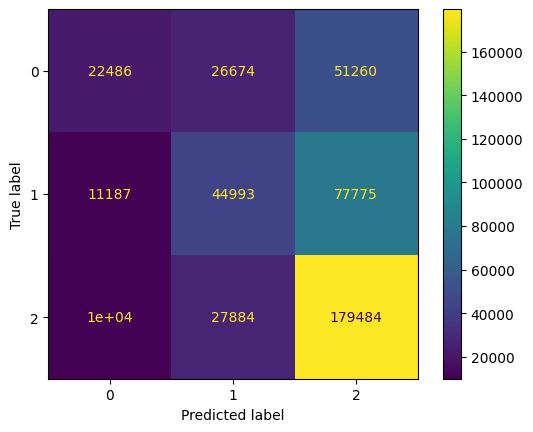

Accuracy: 0.54665
Recall: [0.22391954 0.33588145 0.82558198]
Precision: [0.5144596  0.4519593  0.58175996]
F-1 score: [0.3120282  0.38536911 0.68254988]

stemming=False, normalize=True, add_sentiment=True, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

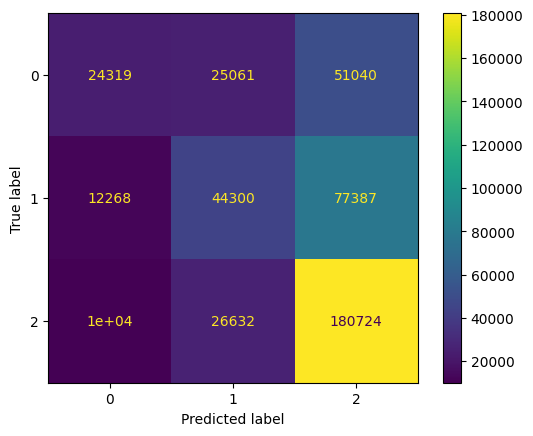

Accuracy: 0.55191
Recall: [0.24217287 0.33070807 0.83128568]
Precision: [0.52148647 0.46149198 0.58458164]
F-1 score: [0.33074925 0.3853045  0.68644052]

stemming=False, normalize=True, add_sentiment=True, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


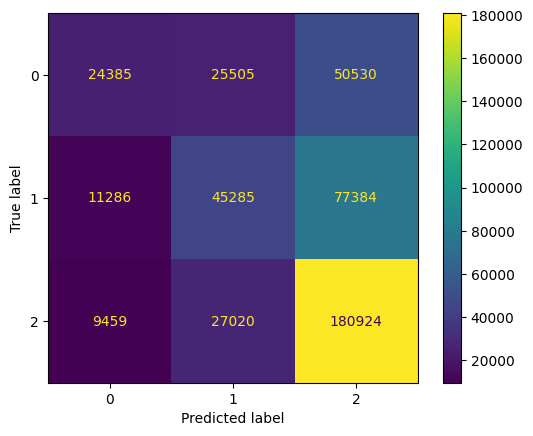

Accuracy: 0.55468
Recall: [0.24283011 0.33806129 0.83220563]
Precision: [0.54032794 0.46298947 0.58582169]
F-1 score: [0.33507386 0.39078377 0.68760891]

stemming=False, normalize=True, add_sentiment=False, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

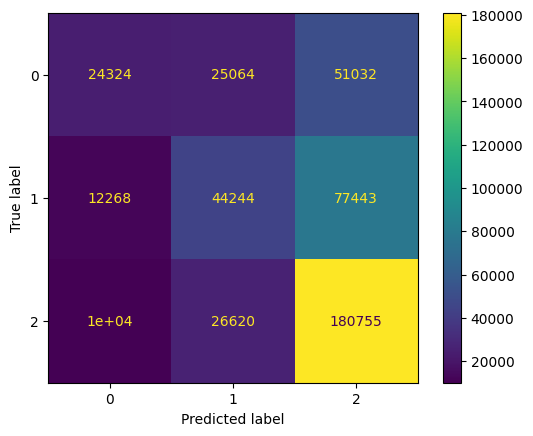

Accuracy: 0.55187
Recall: [0.24222266 0.33029002 0.83142827]
Precision: [0.52175032 0.46122092 0.58453255]
F-1 score: [0.33084875 0.38492625 0.68645527]

stemming=False, normalize=True, add_sentiment=False, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


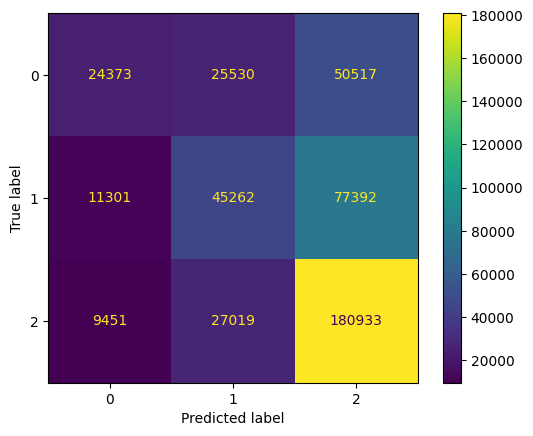

Accuracy: 0.55463
Recall: [0.24271062 0.33788959 0.83224703]
Precision: [0.54012188 0.46274959 0.58584325]
F-1 score: [0.33492047 0.39058361 0.68763789]

stemming=True, normalize=False, add_sentiment=True, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

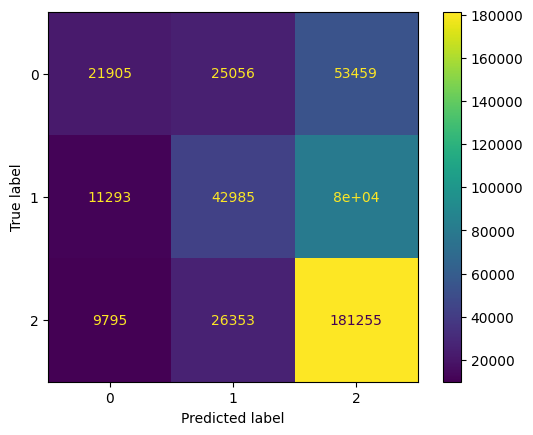

Accuracy: 0.54484
Recall: [0.21813384 0.32089134 0.83372815]
Precision: [0.50950155 0.45537852 0.57652732]
F-1 score: [0.30548137 0.37648512 0.68167373]

stemming=True, normalize=False, add_sentiment=True, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


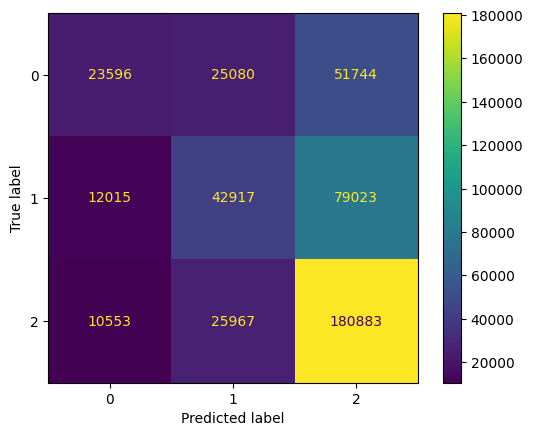

Accuracy: 0.54761
Recall: [0.23497311 0.32038371 0.83201704]
Precision: [0.51113422 0.45673875 0.5804043 ]
F-1 score: [0.3219451  0.3765987  0.68379917]

stemming=True, normalize=False, add_sentiment=False, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

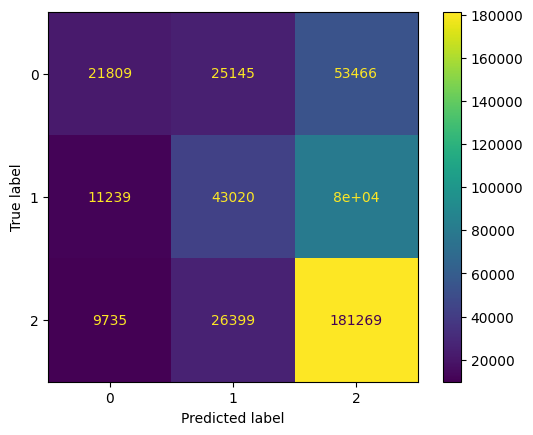

Accuracy: 0.54473
Recall: [0.21717785 0.32115263 0.83379254]
Precision: [0.50975855 0.45492999 0.5764985 ]
F-1 score: [0.30458859 0.37651136 0.68167511]

stemming=True, normalize=False, add_sentiment=False, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


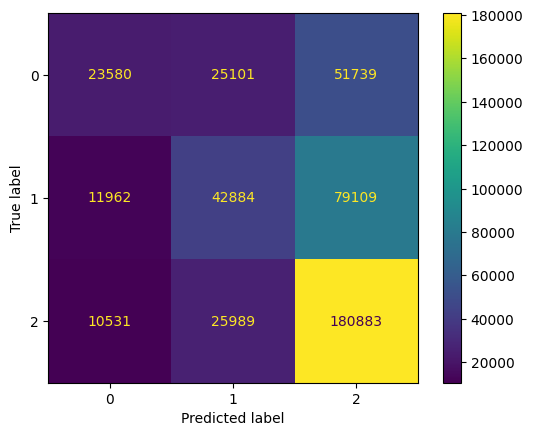

Accuracy: 0.5475
Recall: [0.23481378 0.32013736 0.83201704]
Precision: [0.5117965  0.45633899 0.58025349]
F-1 score: [0.32192664 0.37629262 0.68369449]

stemming=False, normalize=False, add_sentiment=True, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

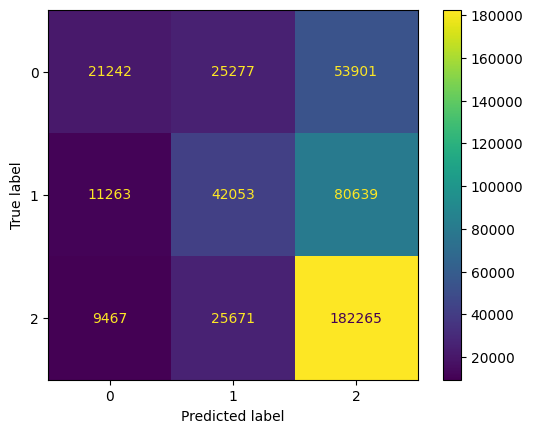

Accuracy: 0.54354
Recall: [0.21153157 0.31393378 0.8383739 ]
Precision: [0.5060993  0.45217793 0.57532236]
F-1 score: [0.29835946 0.37058284 0.68237466]

stemming=False, normalize=False, add_sentiment=True, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


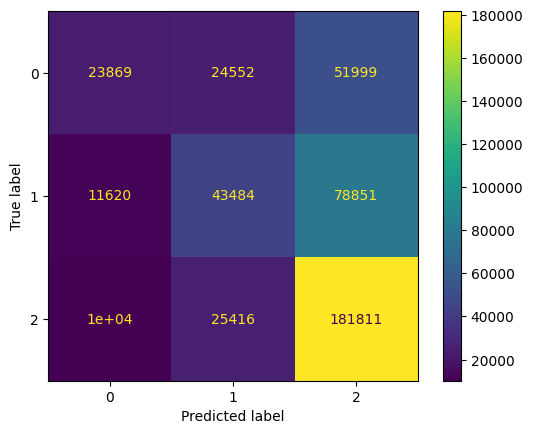

Accuracy: 0.55152
Recall: [0.23769169 0.32461648 0.83628561]
Precision: [0.52269791 0.46530839 0.58149561]
F-1 score: [0.32678235 0.38243326 0.68599641]

stemming=False, normalize=False, add_sentiment=False, add_location=True, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

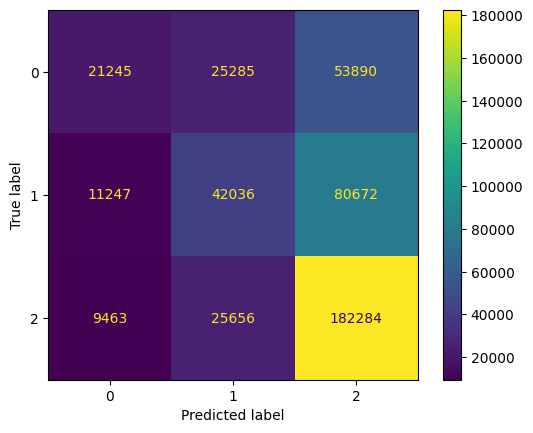

Accuracy: 0.54355
Recall: [0.21156144 0.31380688 0.83846129]
Precision: [0.50637588 0.45211181 0.57530788]
F-1 score: [0.29843723 0.37047221 0.68239342]

stemming=False, normalize=False, add_sentiment=False, add_location=False, dimension_reduction='svd'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(


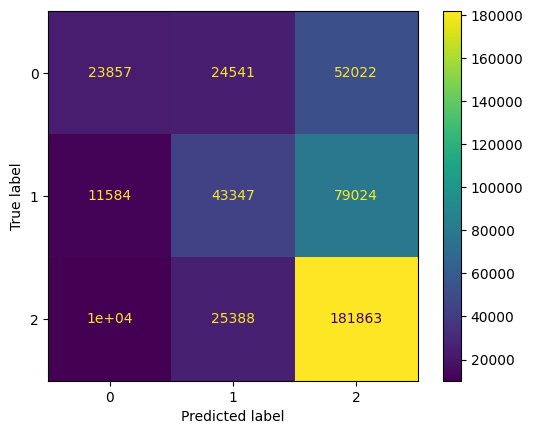

Accuracy: 0.5513
Recall: [0.2375722  0.32359374 0.83652479]
Precision: [0.52326015 0.46471761 0.58120092]
F-1 score: [0.32677912 0.38152365 0.68587171]

stemming=True, normalize=True, add_sentiment=True, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

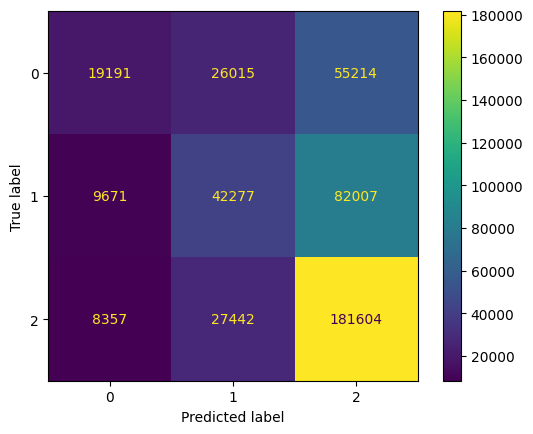

Accuracy: 0.53803
Recall: [0.19110735 0.31560599 0.83533346]
Precision: [0.51562374 0.44160904 0.56960401]
F-1 score: [0.27885992 0.36812385 0.67733874]

stemming=True, normalize=True, add_sentiment=True, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


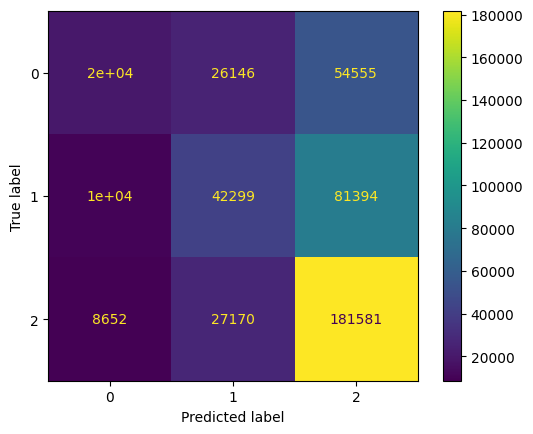

Accuracy: 0.5392
Recall: [0.19636527 0.31577022 0.83522766]
Precision: [0.51041855 0.44238875 0.57185463]
F-1 score: [0.28361848 0.36850634 0.6788925 ]

stemming=True, normalize=True, add_sentiment=False, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

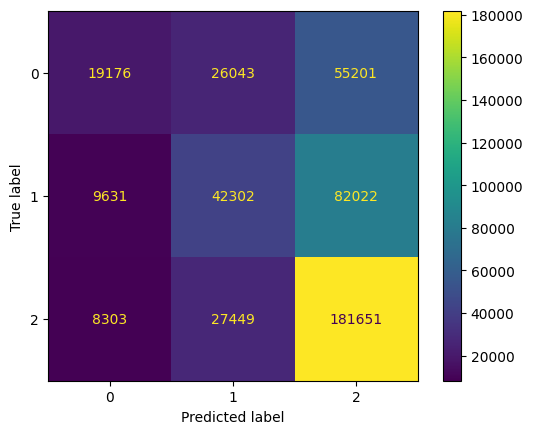

Accuracy: 0.53816
Recall: [0.19095798 0.31579262 0.83554965]
Precision: [0.51673403 0.44159342 0.56966388]
F-1 score: [0.27886279 0.36824535 0.67745214]

stemming=True, normalize=True, add_sentiment=False, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


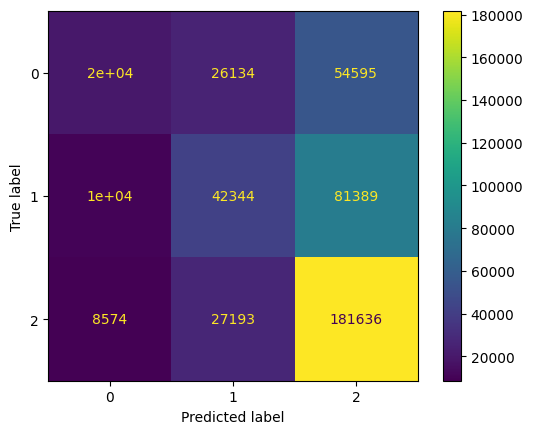

Accuracy: 0.53936
Recall: [0.19608644 0.31610616 0.83548065]
Precision: [0.5116273  0.44260016 0.57186575]
F-1 score: [0.28351343 0.36880841 0.67898389]

stemming=False, normalize=True, add_sentiment=True, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

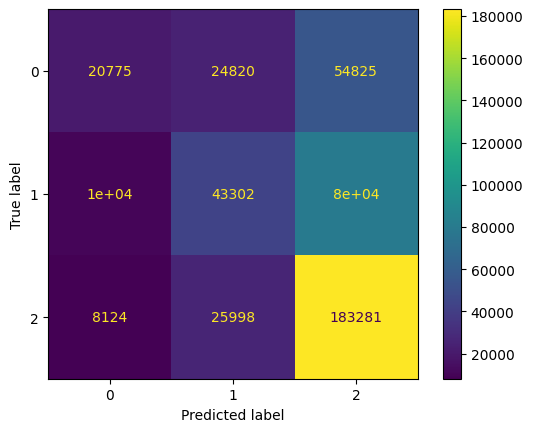

Accuracy: 0.54752
Recall: [0.2068811  0.32325781 0.84304724]
Precision: [0.52851837 0.46007225 0.57572169]
F-1 score: [0.29736345 0.3797172  0.68419962]

stemming=False, normalize=True, add_sentiment=True, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


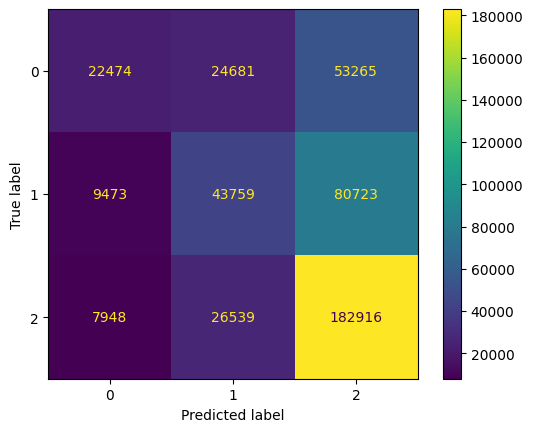

Accuracy: 0.55149
Recall: [0.22380004 0.3266694  0.84136833]
Precision: [0.56332874 0.4607229  0.57719688]
F-1 score: [0.32033639 0.38228485 0.68468502]

stemming=False, normalize=True, add_sentiment=False, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

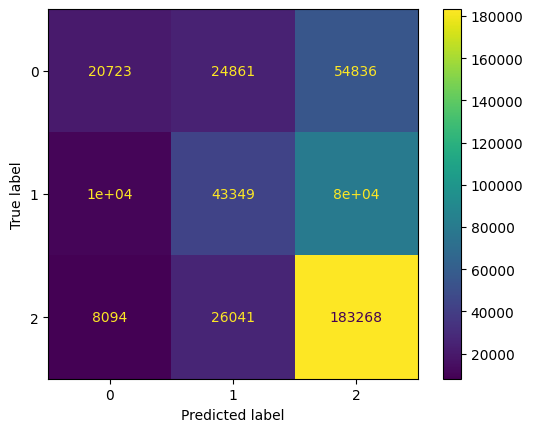

Accuracy: 0.54748
Recall: [0.20636327 0.32360867 0.84298745]
Precision: [0.52906635 0.45993146 0.57566639]
F-1 score: [0.29691451 0.37991113 0.68414088]

stemming=False, normalize=True, add_sentiment=False, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


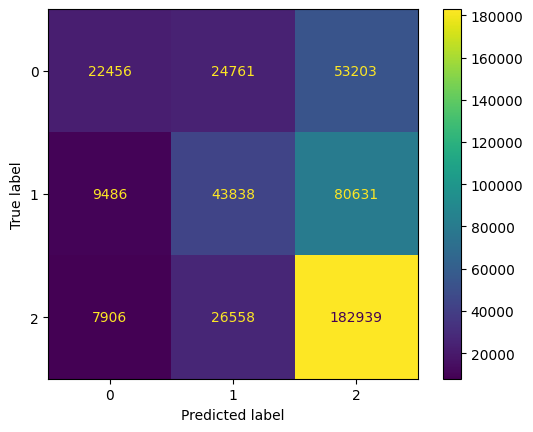

Accuracy: 0.55167
Recall: [0.22362079 0.32725915 0.84147413]
Precision: [0.56354146 0.46069128 0.57750818]
F-1 score: [0.32018707 0.38267747 0.68493905]

stemming=True, normalize=False, add_sentiment=True, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

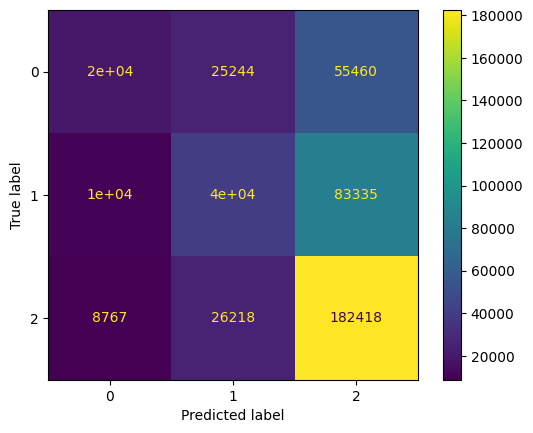

Accuracy: 0.53678
Recall: [0.19633539 0.30139226 0.83907766]
Precision: [0.50906274 0.43962542 0.56790354]
F-1 score: [0.28337765 0.35761548 0.67735827]

stemming=True, normalize=False, add_sentiment=True, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


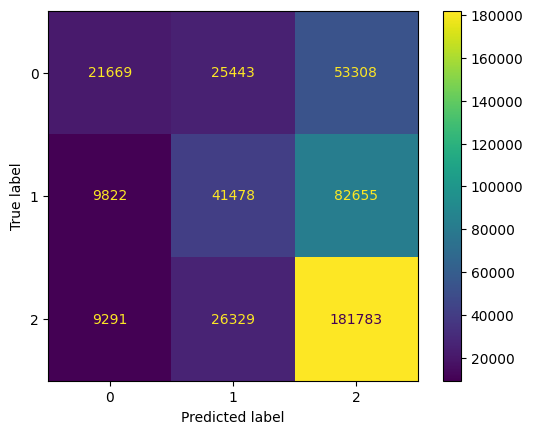

Accuracy: 0.54215
Recall: [0.21578371 0.3096413  0.83615681]
Precision: [0.53133735 0.44480429 0.57210162]
F-1 score: [0.306922   0.3651152  0.67937341]

stemming=True, normalize=False, add_sentiment=False, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

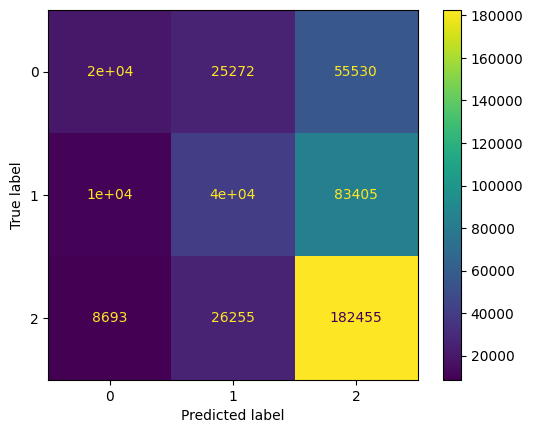

Accuracy: 0.53668
Recall: [0.19535949 0.30148184 0.83924785]
Precision: [0.50987629 0.43938768 0.5677059 ]
F-1 score: [0.28248474 0.35759983 0.67727309]

stemming=True, normalize=False, add_sentiment=False, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


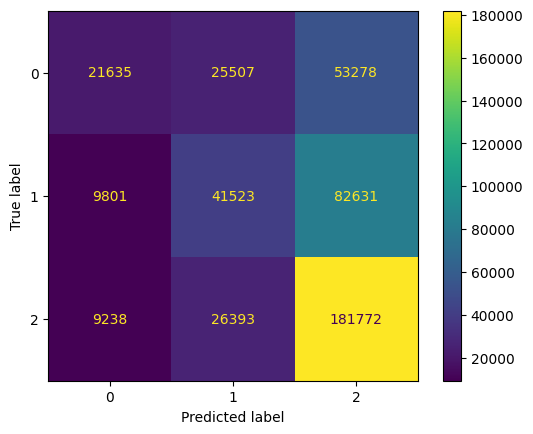

Accuracy: 0.54215
Recall: [0.21544513 0.30997723 0.83610622]
Precision: [0.53191228 0.44446228 0.57218405]
F-1 score: [0.30667498 0.36523322 0.67941482]

stemming=False, normalize=False, add_sentiment=True, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

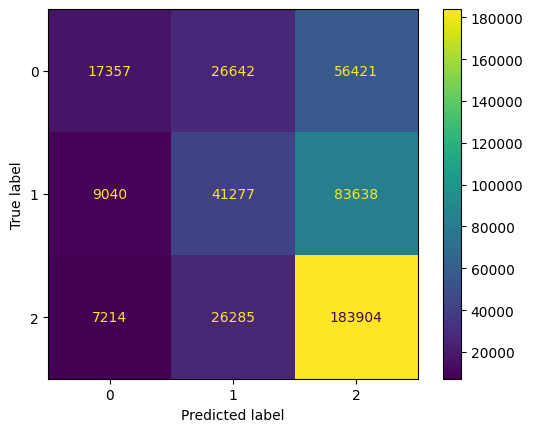

Accuracy: 0.53685
Recall: [0.17284405 0.30814079 0.84591289]
Precision: [0.51640832 0.43816611 0.56766976]
F-1 score: [0.25899978 0.36182662 0.67940728]

stemming=False, normalize=False, add_sentiment=True, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


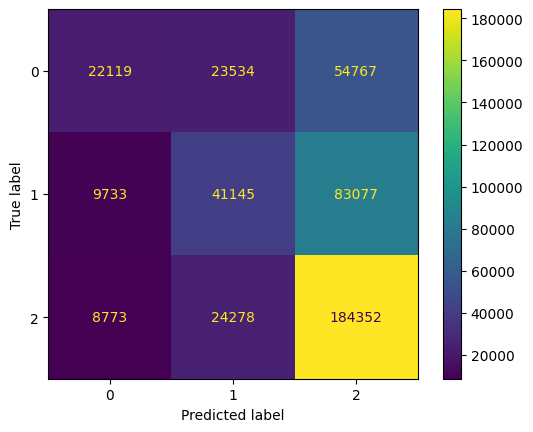

Accuracy: 0.54809
Recall: [0.22026489 0.30715539 0.84797358]
Precision: [0.54446769 0.46252684 0.57217346]
F-1 score: [0.31364458 0.36915913 0.68329259]

stemming=False, normalize=False, add_sentiment=False, add_location=True, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

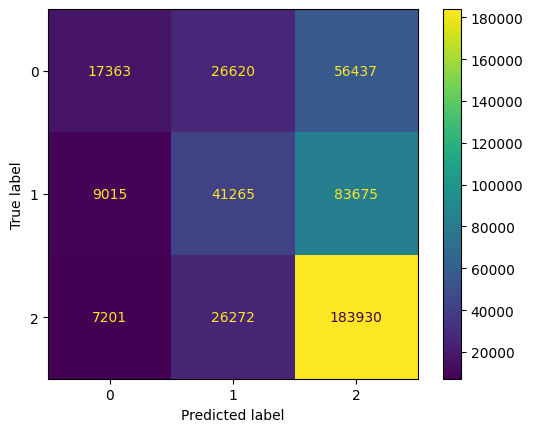

Accuracy: 0.5369
Recall: [0.1729038  0.30805121 0.84603248]
Precision: [0.51707913 0.43825738 0.56761161]
F-1 score: [0.25915119 0.36179596 0.67940419]

stemming=False, normalize=False, add_sentiment=False, add_location=False, dimension_reduction='nmf'


/tmp/ipykernel_7394/588642200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mul["full_text_processed"] = pool.starmap(
/tmp/ipykernel_7394/588642200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mul["full_text_processed"] = pool.starmap(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


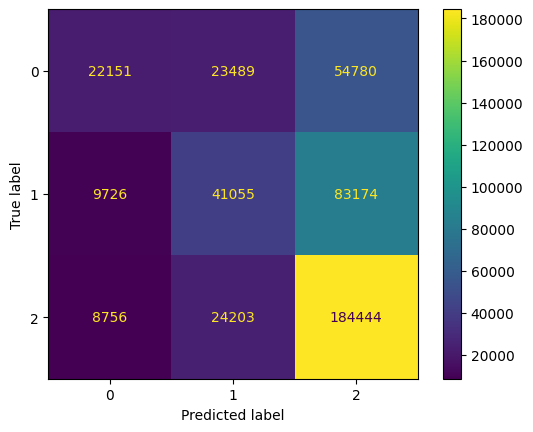

Accuracy: 0.54817
Recall: [0.22058355 0.30648352 0.84839676]
Precision: [0.54514803 0.46260719 0.57210032]
F-1 score: [0.31408052 0.36869898 0.68337776]



{(True, True, True, True, 'svd'): 0.54272,
 (True, True, False, True, 'svd'): 0.54666,
 (True, True, True, False, 'svd'): 0.54273,
 (True, True, False, False, 'svd'): 0.54665,
 (False, True, True, True, 'svd'): 0.55191,
 (False, True, False, True, 'svd'): 0.55468,
 (False, True, True, False, 'svd'): 0.55187,
 (False, True, False, False, 'svd'): 0.55463,
 (True, False, True, True, 'svd'): 0.54484,
 (True, False, False, True, 'svd'): 0.54761,
 (True, False, True, False, 'svd'): 0.54473,
 (True, False, False, False, 'svd'): 0.5475,
 (False, False, True, True, 'svd'): 0.54354,
 (False, False, False, True, 'svd'): 0.55152,
 (False, False, True, False, 'svd'): 0.54355,
 (False, False, False, False, 'svd'): 0.5513,
 (True, True, True, True, 'nmf'): 0.53803,
 (True, True, False, True, 'nmf'): 0.5392,
 (True, True, True, False, 'nmf'): 0.53816,
 (True, True, False, False, 'nmf'): 0.53936,
 (False, True, True, True, 'nmf'): 0.54752,
 (False, True, False, True, 'nmf'): 0.55149,
 (False, True, Tru

In [14]:
params2acc = {}

for dimension_reduction in ["svd", "nmf"]:
    for normalize in [True, False]:
        for stemming in [True, False]:
            for add_sentiment in [True, False]:
                for add_location in [True, False]:
                    print(
                        f"{stemming=}, {normalize=}, {add_sentiment=}, "
                        f"{add_location=}, {dimension_reduction=}"
                    )
                    acc = run_pipeline_and_get_accuracy(
                        stemming,
                        normalize,
                        add_location,
                        add_sentiment,
                        dimension_reduction,
                    )
                    params2acc[
                        (
                            stemming,
                            normalize,
                            add_location,
                            add_sentiment,
                            dimension_reduction,
                        )
                    ] = acc

params2acc

In [15]:
(
    best_stemming,
    best_normalize,
    best_add_location,
    best_add_sentiment,
    best_dimension_reduction,
) = max(params2acc, key=params2acc.get)

(
    best_stemming,
    best_normalize,
    best_add_location,
    best_add_sentiment,
    best_dimension_reduction,
)

(False, True, False, True, 'svd')

In [16]:
params2acc[
    (
        best_stemming,
        best_normalize,
        best_add_location,
        best_add_sentiment,
        best_dimension_reduction,
    )
]

0.55468

### Sentence Transformer (Pre-trained Embeddings)

In [1]:
with Pool(24) as pool:
    data_df["full_text_processed"] = pool.starmap(
        preprocess_text,
        [(t, best_stemming, best_normalize) for t in data_df["full_text"]],
    )
    
    if best_add_location:
        data_df["full_text_processed"] += " " + data_df["location"]

    if best_add_sentiment:
        sentiments = pool.map(get_sentiment, data_df["full_text_processed"])

In [18]:
model_name = "all-mpnet-base-v2"
model = SentenceTransformer(model_name)
st_embeddings = model.encode(data_df["full_text_processed"], show_progress_bar=True)
if best_add_sentiment:
    st_embeddings = np.concatenate(
        (st_embeddings, np.expand_dims(np.array(sentiments), 1)), axis=1
    )
train_st_embeddings, test_st_embeddings = (
    st_embeddings[train_idxs], st_embeddings[test_idxs]
)

Batches:   0%|          | 0/15687 [00:00<?, ?it/s]

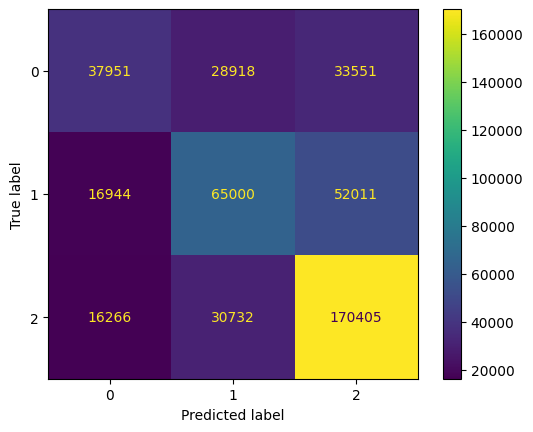

Accuracy: 0.60507
Recall: [0.37792272 0.48523758 0.78382083]
Precision: [0.53331179 0.52146009 0.66573035]
F-1 score: [0.44236833 0.50269716 0.71996535]



0.60507

In [19]:
one_one_svm = OneVsOneClassifier(LinearSVC(random_state=SEED))
y_pred = one_one_svm.fit(
    train_st_embeddings, train_mul["leading_label_cat"]
).predict(test_st_embeddings)
evaluate_mul(test_mul["leading_label_cat"], y_pred, average=None, clf=one_one_svm)

### Fine-tune Sequence-Classifying Transfomer

In [2]:
import torch
from transformers import AutoTokenizer


train_idxs_array = np.array(train_idxs)
train_idxs, valid_idxs = get_train_test_indices(len(train_idxs), test_size=0.2)
train_idxs, valid_idxs = train_idxs_array[train_idxs], train_idxs_array[valid_idxs]
X_train = data_df["full_text_processed"].values[train_idxs]
X_valid = data_df["full_text_processed"].values[valid_idxs]
X_test = data_df["full_text_processed"].values[test_idxs]
y_train = data_df["leading_label_cat"].values[train_idxs]
y_valid = data_df["leading_label_cat"].values[valid_idxs]
y_test = data_df["leading_label_cat"].values[test_idxs]

In [21]:
y_test = data_df["leading_label_cat"].values[test_idxs]

In [21]:
model_path = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [22]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TweetDataset(train_encodings, y_train)
valid_dataset = TweetDataset(valid_encodings, y_valid)
test_dataset = TweetDataset(test_encodings, y_test)

In [23]:
from datasets import load_metric


metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_7394/1904029880.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [24]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments


batch_size = 16
n_epoch = 3
total_steps = round(len(y_train) / batch_size * n_epoch)
warmup_steps = total_steps * 0.5

training_args = TrainingArguments(
    output_dir="/tmp2/kch/ece219/results",
    learning_rate=1e-5,
    num_train_epochs=n_epoch,                # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=64,           # batch size for evaluation
    warmup_steps=warmup_steps,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                       # strength of weight decay
    logging_dir="./logs",                    # directory for storing logs
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
)

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy
1000,0.976100,0.959735,0.519422
2000,0.909400,0.911188,0.540538
3000,0.881600,0.864862,0.579980
4000,0.818900,0.824667,0.608466
5000,0.801100,0.788632,0.629582
6000,0.745100,0.785404,0.632769
7000,0.727500,0.786178,0.636753


***** Running Evaluation *****
  Num examples = 10040
  Batch size = 64
Saving model checkpoint to /tmp2/kch/ece219/results/checkpoint-1000
Configuration saved in /tmp2/kch/ece219/results/checkpoint-1000/config.json
Model weights saved in /tmp2/kch/ece219/results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10040
  Batch size = 64
Saving model checkpoint to /tmp2/kch/ece219/results/checkpoint-2000
Configuration saved in /tmp2/kch/ece219/results/checkpoint-2000/config.json
Model weights saved in /tmp2/kch/ece219/results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10040
  Batch size = 64
Saving model checkpoint to /tmp2/kch/ece219/results/checkpoint-3000
Configuration saved in /tmp2/kch/ece219/results/checkpoint-3000/config.json
Model weights saved in /tmp2/kch/ece219/results/checkpoint-3000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10040
  Batch size = 64
Saving model checkpoint to /tmp2/k

TrainOutput(global_step=7530, training_loss=0.8443113258635381, metrics={'train_runtime': 6172.508, 'train_samples_per_second': 19.518, 'train_steps_per_second': 1.22, 'total_flos': 2.3959476793768572e+16, 'train_loss': 0.8443113258635381, 'epoch': 3.0})

In [25]:
y_pred = trainer.predict(test_dataset).predictions.argmax(axis=1)

***** Running Prediction *****
  Num examples = 451778
  Batch size = 64


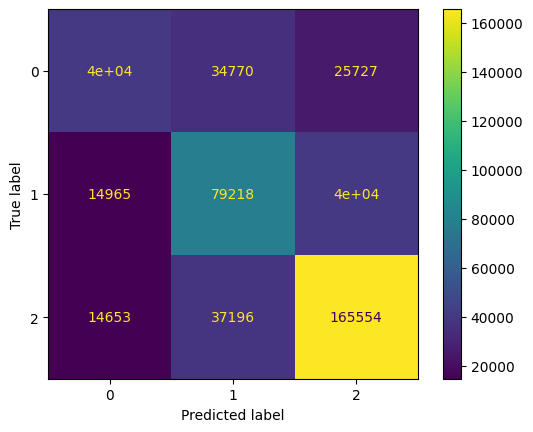

Accuracy: 0.63017
Recall: [0.39756025 0.5913777  0.76150743]
Precision: [0.57409298 0.52398402 0.71651959]
F-1 score: [0.46979013 0.55564479 0.73832884]



0.63017

In [26]:
evaluate_mul(y_test, y_pred, average=None, clf=None)

### Weak Baselines

  0%|          | 0/451778 [00:00<?, ?it/s]

Counter({2: 365015, 1: 45599, 0: 41164})


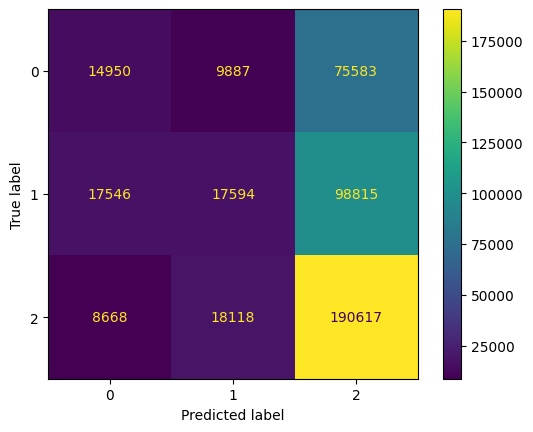

Accuracy: 0.49396
Recall: [0.14887473 0.13134262 0.87679103]
Precision: [0.36318142 0.38584179 0.5222169 ]
F-1 score: [0.21118205 0.19597447 0.65457112]



0.49396

In [30]:
from collections import Counter


def rule_based_predict(text):
    lower_text = text.lower()
    sea_kws = [
        "seahawk", "seattle", "marshawn", "lynch", "steven", "hauschka",
        "chris", "matthews", "russell", "wilson", "doug", "baldwin",
    ]
    ne_kws = [
        "patriot", "newengland", "tom", "brady", "stephen", "gostkowski",
        "brandon", "lafell", "rob", "gronkowski", "danny", "amendola",
        "julian", "edelman",
    ]
    sea = ne = False
    
    for sea_kw in sea_kws:
        if sea_kw in lower_text:
            sea = True
            break
    
    for ne_kw in ne_kws:
        if ne_kw in lower_text:
            ne = True
            break

    if ne and not sea:
        return 0
    if sea and not ne:
        return 1
    return 2


y_pred_rule_based = [rule_based_predict(t) for t in tqdm(test_mul["full_text"])]
print(Counter(y_pred_rule_based))
evaluate_mul(y_test, y_pred_rule_based, average=None, clf=None)

In [28]:
round(Counter(test_mul["leading_label"])["TIE"] / len(test_idxs), 5)

0.48122

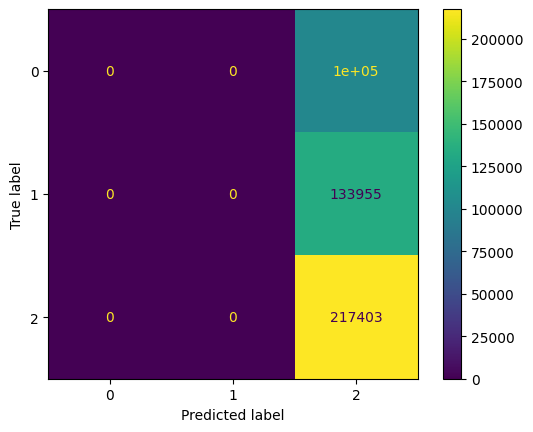

Accuracy: 0.48122
Recall: [0. 0. 1.]


/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: [0.         0.         0.48121644]
F-1 score: [0.         0.         0.64975844]



0.48122

In [25]:
evaluate_mul(y_test, [2] * len(y_test), average=None, clf=None)

In [29]:
### Data
# normalize (o)
# normalize advanced (o)
# hashtag split (o)
# sentiment (o)
# emoji (o)

### Model
# w NMF (o)
# w SVD (o)
# ensemble
# fasttext
# roberta or xxbert

### Baseline
# 2+
# raw data
# no extra preprocess

### Report


############ TODO #############

# 1. Pipeline [done]
# 2. Baseline
# 3. textrnngen
# 4. Report